### Import lib

In [160]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import sys 
import os
sys.path.append(os.path.abspath("/Users/evamartinez/Code/ocr_segmentez_client"))
import segmentez as seg

### Load Csv

In [161]:
df_orders_dataset = pd.read_csv('olist_orders_dataset.csv')
df_orders_dataset = df_orders_dataset.set_index('order_id')
print(df_orders_dataset.columns)
print(len(df_orders_dataset))

df_order_reviews_dataset = pd.read_csv('olist_order_reviews_dataset.csv')
df_order_reviews_dataset = df_order_reviews_dataset.set_index('order_id')
print(df_order_reviews_dataset.columns)
print(len(df_order_reviews_dataset))

df_customers_dataset = pd.read_csv('olist_customers_dataset.csv')
df_customers_dataset = df_customers_dataset.set_index('customer_id')
print(df_customers_dataset.columns)
print(len(df_customers_dataset))

df_order_payments_dataset = pd.read_csv('olist_order_payments_dataset.csv')
df_order_payments_dataset_cropped = df_order_payments_dataset[['payment_value','order_id']]
df_order_payments_gb = df_order_payments_dataset_cropped.groupby('order_id').sum()
print(df_order_payments_gb.columns)
print(len(df_order_payments_gb))


Index(['customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
99441
Index(['review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
99224
Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
99441
Index(['payment_value'], dtype='object')
99440


### Merge all the csv

In [162]:
df_merge_1= pd.merge(df_orders_dataset,                          
                       df_order_reviews_dataset,
                       left_index = True,
                       right_index = True,how='inner')
print(len(df_merge_1))

df_merge_1['order_id']=df_merge_1.index
df_merge_1 = df_merge_1.set_index('customer_id')


df_merge_2 = pd.merge(df_merge_1,                          
                       df_customers_dataset,
                       left_index = True,
                       right_index = True,how='inner')
print(len(df_merge_2))

df_merge_2 = df_merge_2.set_index('order_id')
df_merge_2['order_id']=df_merge_2.index

df_merge_final = pd.merge(df_merge_2,                          
                       df_order_payments_gb,
                       left_index = True,
                       right_index = True,how='inner')

print(len(df_merge_final))
print(df_merge_final.columns)

df_merge_final.to_csv('df_orders_final.csv')





99224
99224
99223
Index(['order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_id', 'payment_value'],
      dtype='object')


### Groupby

In [163]:
df_recence = df_merge_final[['order_purchase_timestamp','customer_unique_id']]
df_recence_gb = df_recence.groupby('customer_unique_id').max()
df_recence_gb = df_recence_gb.rename(columns={"order_purchase_timestamp": "recence_date"})
print('df_recence_gb',len(df_recence_gb))


df_frequence = df_merge_final[['order_purchase_timestamp','customer_unique_id']]
df_frequence_gb = df_frequence.groupby('customer_unique_id').count()
df_frequence_gb = df_frequence_gb.rename(columns={"order_purchase_timestamp": "frequence"})
print('df_frequence_gb',len(df_frequence_gb))

df_montant = df_merge_final[['payment_value','customer_unique_id']]
df_montant_gb = df_montant.groupby('customer_unique_id').sum()
df_montant_gb = df_montant_gb.rename(columns={"payment_value": "monetary"})
print('df_montant_gb',len(df_montant_gb))

df_review = df_merge_final[['review_score','customer_unique_id']]
df_review_gb = df_review.groupby('customer_unique_id').mean()
print('df_review_gb',len(df_review_gb))


df_recence_gb 95379
df_frequence_gb 95379
df_montant_gb 95379
df_review_gb 95379


### Change recence/date by recence/day

In [164]:
datetime_list = []

for i in df_recence_gb['recence_date']:
  datetime_object = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
  datetime_list.append(datetime_object)

df_recence_gb['recence_date'] = datetime_list
recence_range = df_recence_gb['recence_date'].max()-df_recence_gb['recence_date'].min()
print('recence_date',recence_range )

datetime_relative_list=[]
for i in df_recence_gb['recence_date']:
  relative_recence = df_recence_gb['recence_date'].max() - i
  relative_recence = relative_recence.days
  datetime_relative_list.append(relative_recence)

df_recence_gb['recence']= datetime_relative_list
del df_recence_gb['recence_date']


recence_date 772 days 20:14:59


### Build df rfmr

len(df_rfmr) 95379
Index(['recence', 'frequence', 'monetary', 'review_score'], dtype='object')
Filling of rfmr
<class 'pandas.core.frame.DataFrame'>
Index: 95379 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recence       95379 non-null  int64  
 1   frequence     95379 non-null  int64  
 2   monetary      95379 non-null  float64
 3   review_score  95379 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 5.7+ MB


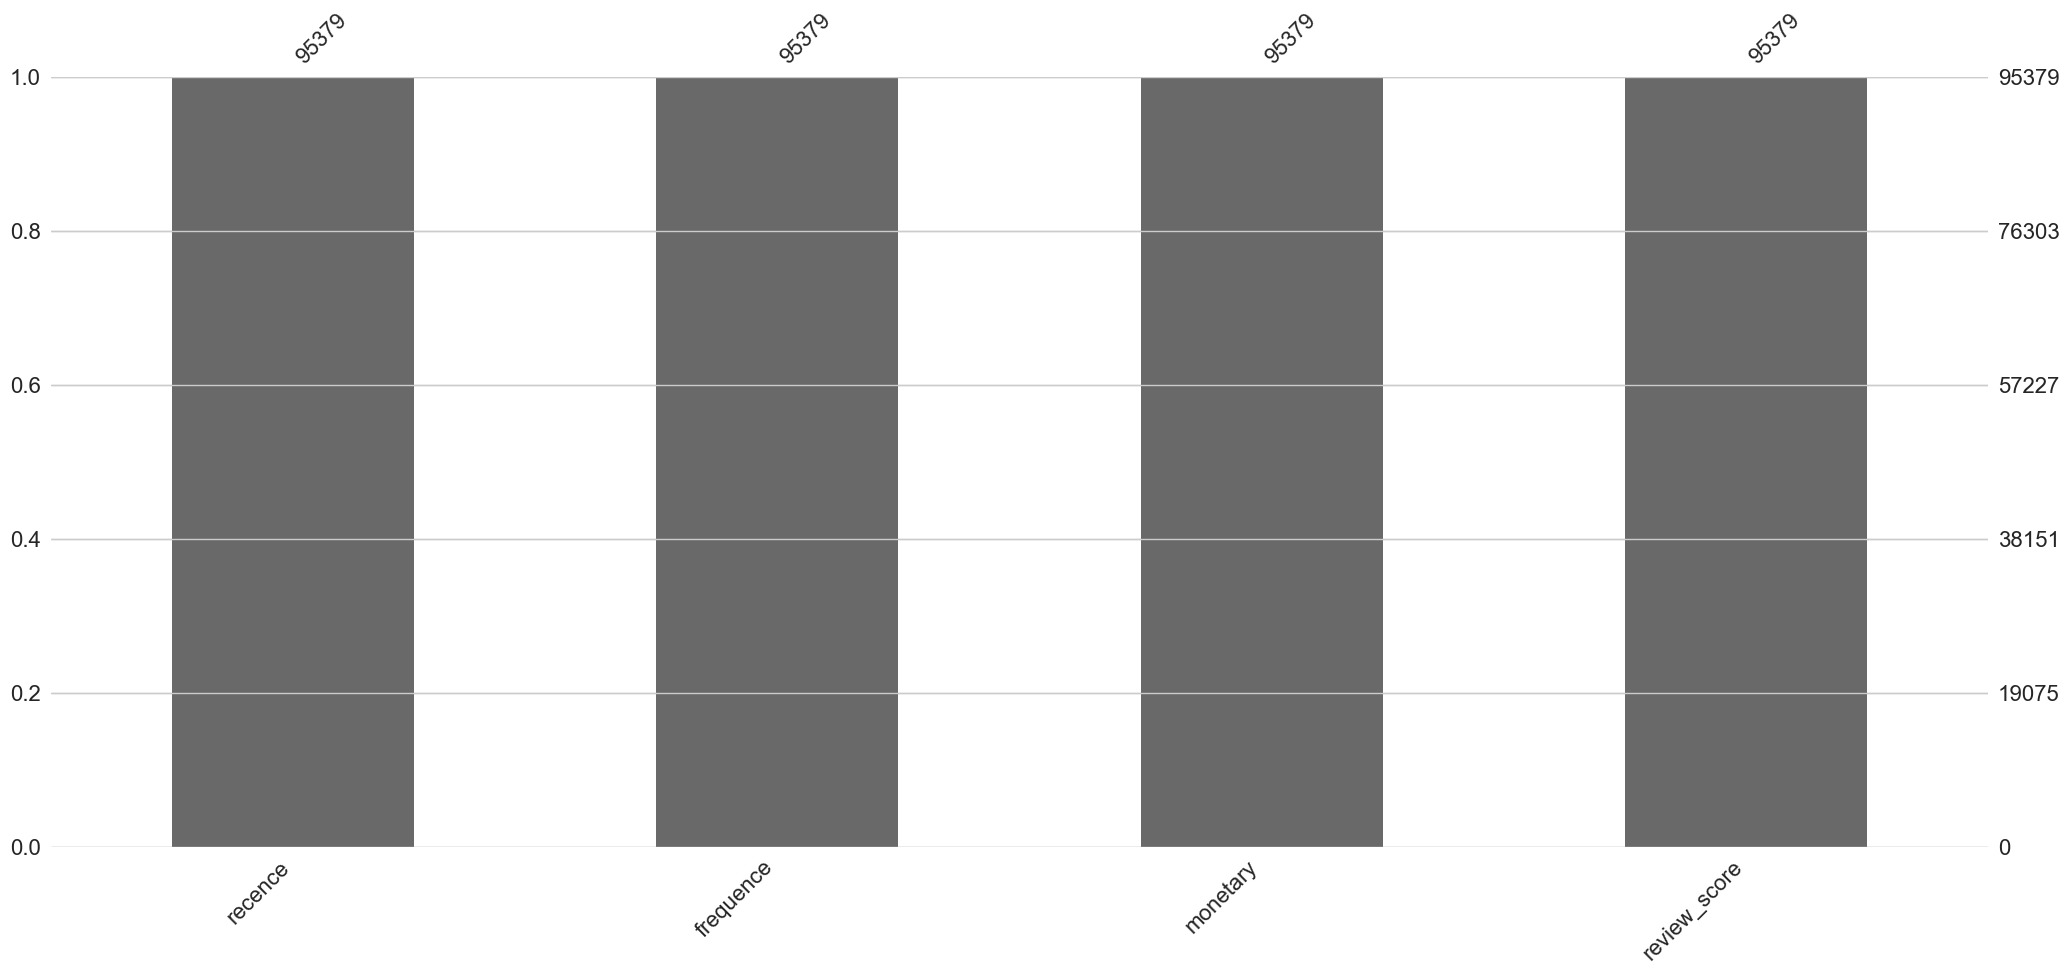

In [165]:
df_rf = df_recence_gb.join(df_frequence_gb)
df_rfm = df_rf.join(df_montant_gb)
df_rfmr = df_rfm.join(df_review_gb)
df_rfmr = df_rfmr.dropna()
print('len(df_rfmr)',len(df_rfmr))
print(df_rfmr.columns)

print('Filling of rfmr')
%matplotlib inline
msno.bar(df_rfmr)
df_rfmr.info(verbose=True)


### Distribution

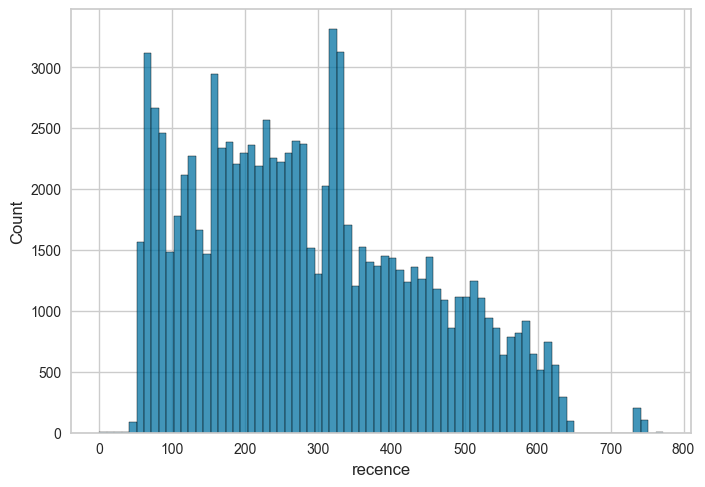

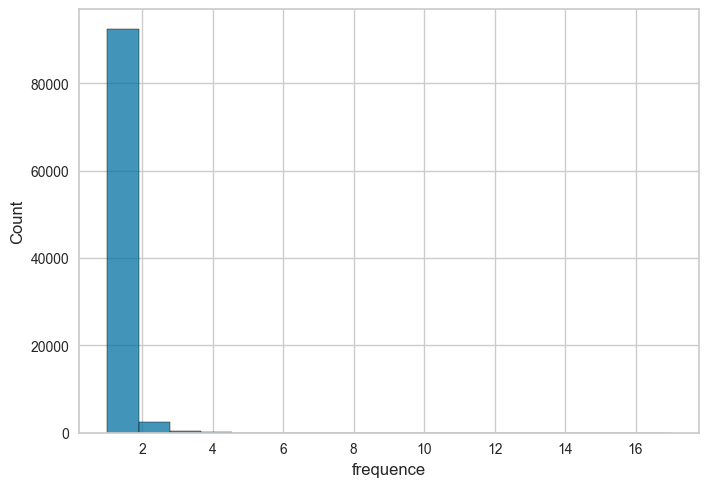

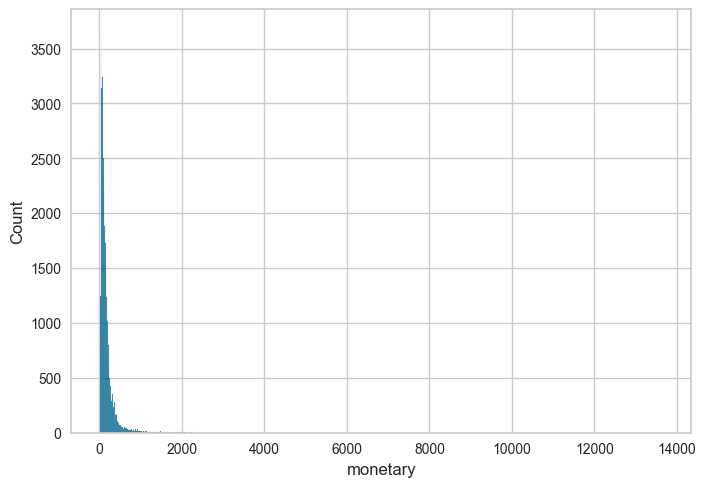

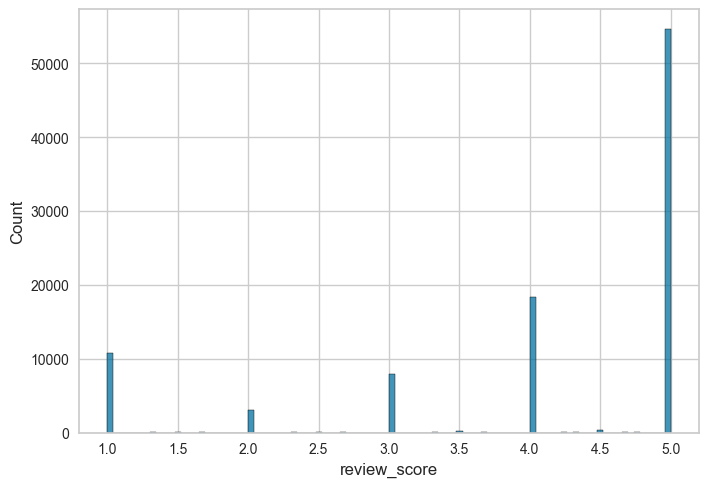

In [166]:
col = df_rfmr.columns

# Histograms
for i, col in enumerate(df_rfmr):
  plt.figure(i)
  sns.histplot(df_rfmr[col])
  plt.savefig("hist"+str(i)+".png")


### Refactoring

In [167]:
df_rfmr = df_rfmr.sample(50000)
df_rfmr.dropna()
df_rfmr = df_rfmr[df_rfmr['monetary']>0]
df_rfmr = df_rfmr[df_rfmr['frequence']>0]
df_rfmr = df_rfmr[df_rfmr['recence']>0]

print('len df_rfmr_raw :', len(df_rfmr))

df_rfmr.to_csv('df_rfmr_raw.csv')



len df_rfmr_raw : 49998


#### Frequency

<Axes: xlabel='frequence', ylabel='Count'>

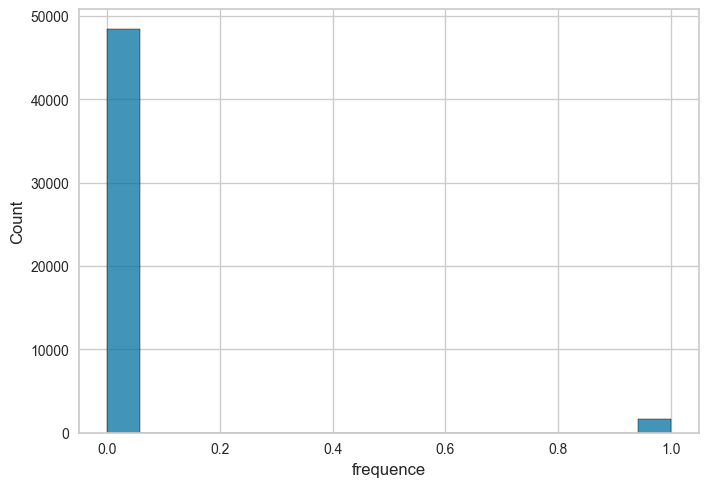

In [168]:
frequency_refac = df_rfmr['frequence']
list_frequency =[]
for i in frequency_refac:
  if i ==1:
    list_frequency.append(0)
  else:
    list_frequency.append(1)

del df_rfmr['frequence']

df_rfmr['frequence'] = list_frequency
sns.histplot(df_rfmr['frequence'])

#### Log for monetary

49998


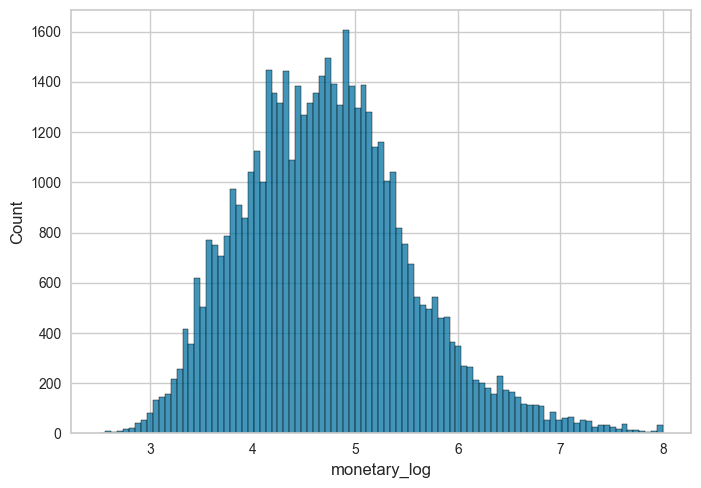

In [169]:
df_rfmr['monetary_log']=np.log(df_rfmr['monetary'])
del df_rfmr['monetary']
df_rfmr.drop(df_rfmr[(df_rfmr['monetary_log'] == -float('inf'))].index, inplace=True)
df_rfmr.loc[df_rfmr['monetary_log'] > 8, 'monetary_log'] = 8
df_rfmr.loc[df_rfmr['monetary_log'] < 2.5, 'monetary_log'] = 2.5
sns.histplot(df_rfmr['monetary_log'])
print(len(df_rfmr))



### Save df for analysis

In [170]:
df_rfmr.to_csv('df_rfmr.csv')
print('len df_rfmr :', len(df_rfmr))
print(df_rfmr.columns)


len df_rfmr : 49998
Index(['recence', 'review_score', 'frequence', 'monetary_log'], dtype='object')
